<a href="https://colab.research.google.com/github/mbmackenzie/peace-speech-project/blob/master/BERT_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# About the Notebook

This notebook implement BERT with Linear layer for the classification purpose.

1. [Data](#section_1)
2. [Model](#section_2)
3. [Random Sampling](#section_3)
4. [Random Sampling Test data](#section_4)
5. [Separate Prediction model](#section_5)
6. [Evaluation Metrics](#section_6)
7. [Save BERT Classifier](#section_7)
8. [Load BERT Classifier](#section_8)



## 1. Data <a class="anchor" id="section_1"></a>

We have used the sampled data of countries from peaceful and non-peaceful nation. For the BERT, we have chosed the n-gram preprocessed text data (no lemmatization and stopword removal). Since BERT takes too much time for the fine-tuning and prediction for evaluation, instead of using whole 874,535 data, we have randomly sampled 100,000 data for train & validation and 50,000 for test. 

In [ ]:
#huggingface library installation
!pip install transformers

import numpy as np
import pandas as pd
import os
from transformers import BertForTokenClassification, AdamW, BertConfig, BertForSequenceClassification, get_linear_schedule_with_warmup
import random
import transformers
from torch.utils.data import TensorDataset, random_split,DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from torch.autograd import Variable
import time
import datetime
from platform import python_version
import sklearn
import torch
import random

from torch import nn
#Using Colab GPU for training
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

#To confirm that we are using GPU for the training later

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


directory = '/content/drive/My Drive/n_gram_processed'
peace = ['AU', 'CA', 'IE', 'NZ', 'SG', 'GB']
non_peace = ['BD', 'KE', 'NG', 'PK', 'TZ']

In [ ]:
df_whole = pd.read_csv('/content/drive/My Drive/whole_df.csv',index_col=[0])

#add labels to the dataframe
df_whole['label'] = -1
for i in range(len(df_whole)):
  if df_whole['country'][i] in peace:
    df_whole['label'][i] = 0
  else:
    df_whole['label'][i] = 1

df_whole = df_whole.dropna()

## 2. Model <a class="anchor" id="section_2"></a>

We have used BERT-base-uncased for the BERT model. Instead of separate each sentence, we have treated the whole document as a sentence, hence add [CLS] and [SEP] at the beginning and end of the document. Since some of the documents has longer token lengths than 512, we have first tried with truncation (only using 510 tokens at the beginning). Although the best method is to use some part from head and some part from tail according to the [article](https://arxiv.org/abs/1905.05583), we have achieved 94% accuracy for both validation and test, hence will not use the method.



In [ ]:
from transformers import *

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
MAX_LEN = 512

#The below code can be later modified to add the segment_id of setences. 
#However, since the summary + title data outperforms the validation accuracy from finBERT, I will modify this after implement the XLNet classifier

def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            sent,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True,      # Return attention mask
            truncation = True
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 100, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 54 µs, sys: 0 ns, total: 54 µs
Wall time: 57.2 µs


In [ ]:
def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=2e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

    
    print("Training complete!")
    return float(val_loss), float(val_accuracy)

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

## 3. Random Sampling <a class="anchor" id="section_3"></a>

We have equally collect 50,000 articles from peaceful and 50,000 articles from non-peaceful countries.

In [ ]:
import random

peace_index = random.sample(list(df_whole[df_whole['label'] == 0].index), 50000)
nonpeaceful_index = random.sample(list(df_whole[df_whole['label'] == 1].index), 50000)
index = peace_index + nonpeaceful_index

X = df_whole['text'][index]
y1 = df_whole['label'][index]
X.index = np.arange(0,len(X))
y1.index = np.arange(0,len(y1))

inputs, masks = preprocessing_for_bert(X)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
from sklearn.model_selection import KFold
#train and val are indices
kf = KFold(n_splits=5, shuffle = True, random_state = 42)


batch_size = 16
train_loss = []
val_loss = []
val_accuracy = []

for train_index, val_index in kf.split(inputs):
  #Data Preparation
  train_inputs = inputs[train_index]
  train_masks = masks[train_index]
  val_inputs = inputs[val_index]
  val_masks = masks[val_index]

  train_labels = torch.tensor(y1[train_index].values)
  val_labels = torch.tensor(y1[val_index].values)
  
  #Data Loader Class
  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

  val_data = TensorDataset(val_inputs, val_masks, val_labels)
  val_sampler = RandomSampler(val_data)
  val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)

  #Fine Tune and Evaluation
  set_seed(42)    # Set seed for reproducibility
  bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
  val_loss1, val_accuracy1 = train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)
  
  val_loss.append(val_loss1)
  val_accuracy.append(val_accuracy1)
  break


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.584987   |     -      |     -     |   18.19  
   1    |   40    |   0.369717   |     -      |     -     |   17.22  
   1    |   60    |   0.333490   |     -      |     -     |   17.28  
   1    |   80    |   0.277348   |     -      |     -     |   17.21  
   1    |   100   |   0.283571   |     -      |     -     |   17.20  
   1    |   120   |   0.153531   |     -      |     -     |   17.23  
   1    |   140   |   0.274527   |     -      |     -     |   17.19  
   1    |   160   |   0.319057   |     -      |     -     |   17.18  
   1    |   180   |   0.223176   |     -      |     -     |   17.22  
   1    |   200   |   0.251742   |     -      |     -     |   17.26  
   1    |   220   |   0.246898   |     -      |     -     |   17.24  
   1    |   240   |   0.286296   |     -      |     -     |   17.18  

TypeError: ignored

## 4. Random Sampling Test data <a class="anchor" id="section_4"></a>



In [ ]:
df_whole.loc[remain_index,:]

,text,country,label
0,gable tostee dumped by' emotional starved' gi...,AU,0
1,news bites from a melbourne icon popping up i...,AU,0
2,made with love kaum celebrates the best of ba...,AU,0
3,this kid is going viral for his perfect revie...,AU,0
4,meghan markle targeted in cruel topless photo...,AU,0
...,...,...,...
874531,african economies suffer effects of global ec...,TZ,1
874532,is china setting a debt trap on keny loans fr...,TZ,1
874533,citi bank launches volunteer africa 2019 prog...,TZ,1
874534,africa's property market thrives on domestic ...,TZ,1


In [ ]:
remain_index = list(set(df_whole.index) - set(index))
peace_index = random.sample(list(df_whole.loc[remain_index,:][df_whole['label'] == 0].index), 25000)
nonpeaceful_index = random.sample(list(df_whole.loc[remain_index,:][df_whole['label'] == 1].index), 25000)

ran_index = peace_index + nonpeaceful_index

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
X_test = df_whole['text'][ran_index]
y1_test = df_whole['label'][ran_index]
X_test.index = np.arange(0,len(X_test))
y1_test.index = np.arange(0,len(y1_test))

test_inputs, test_masks = preprocessing_for_bert(X_test)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
#Data Loader Class
test_labels = torch.tensor(y1_test.values)
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size = batch_size)

## 5. Separate Prediction model <a class="anchor" id="section_5"></a>

Since BERT evaluates with random batches, we need to implement separate function for the prediction.

In [ ]:
def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()
    val_accuracy = []
    all_pred = []
    all_real = []
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
        all_real.append(b_labels)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)


        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()
        all_pred.append(preds)

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    all_real = torch.cat(all_real)
    all_pred = torch.cat(all_pred)
    # Compute the average accuracy and loss over the validation set.
    #val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_accuracy,all_real, all_pred

In [ ]:
acc,all_real, all_pred = bert_predict(bert_classifier, test_dataloader)

## 6. Evaluation Metrics <a class="anchor" id="section_6"></a>

In [ ]:
y_true = all_real.cpu().numpy()
y_pred = all_pred.cpu().numpy()

In [ ]:
from sklearn.metrics import classification_report
#0: peaceful, 1:non_peaceful

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     25000
           1       0.95      0.95      0.95     25000

    accuracy                           0.95     50000
   macro avg       0.95      0.95      0.95     50000
weighted avg       0.95      0.95      0.95     50000



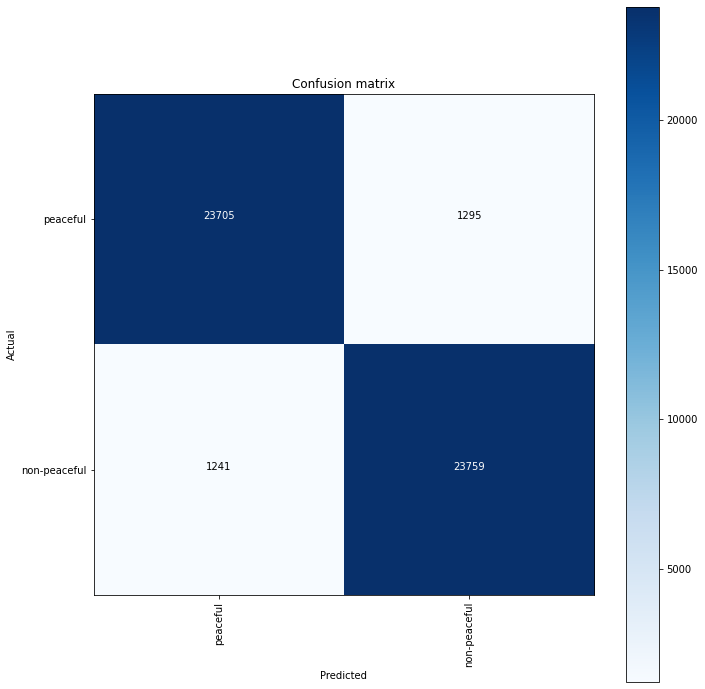

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,normalize=False):
    plt.figure(figsize = (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

dict_characters = {0: 'peaceful', 1: 'non-peaceful'}

# y_pred = model.predict(test_data)
# y_pred_classes = np.argmax(y_pred, axis=1)
# y_true = np.argmax(test_labels, axis=1)

confusion_mat = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(confusion_mat, classes = list(dict_characters.values()))

## 7. Save BERT Classifier <a class="anchor" id="section_7"></a>

In [ ]:
torch.save(bert_classifier.state_dict(), 'bertclassifier.pth')

## 8. Load BERT CLassifier <a class="anchor" id="section_8"></a>

Before load the BERT classifier, Pytorch requires user to define the same model architecture as the train have done.

With the Loaded classifier, one can use it for the inference purpose. Please refer to the [site](https://pytorch.org/tutorials/beginner/saving_loading_models.html) for more detail.

In [ ]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 100, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 60 µs, sys: 0 ns, total: 60 µs
Wall time: 65.3 µs


In [ ]:
the_model = BertClassifier()
the_model.load_state_dict(torch.load('/content/bertclassifier.pth'))
the_model.to(device)

<All keys matched successfully>

In [ ]:
test_acc,test_real, test_pred = bert_predict(the_model, test_dataloader)

In [ ]:
from sklearn.metrics import classification_report
#0: peaceful, 1:non_peaceful
y_true1 = test_real.cpu().numpy()
y_pred1 = test_pred.cpu().numpy()
print(classification_report(y_true1, y_pred1))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96     35506
           1       0.88      0.95      0.91     14494

    accuracy                           0.95     50000
   macro avg       0.93      0.95      0.94     50000
weighted avg       0.95      0.95      0.95     50000

